<a href="https://colab.research.google.com/github/Joseph-Caicedo/Detencion_Mascarillas/blob/main/detenccion_mascarillas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conjunto de datos**

Se carga el conjunto de datos del siguiente repositorio:

In [ ]:
!git clone https://github.com/Joseph-Caicedo/Detenccion_Mascarillas.git

Cloning into 'Detenccion_Mascarillas'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 2931 (delta 53), reused 34 (delta 7), pack-reused 2780
Receiving objects: 100% (2931/2931), 160.53 MiB | 40.65 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (5204/5204), done.


**Nota: La mayor parte del conjunto de datos se obtiene del repositorio ["observations"](https://github.com/prajnasb/observations.git) que es propiedad de [prajnasb](https://github.com/prajnasb) y  de ["MaskDetection"](https://github.com/DavidReveloLuna/MaskDetection.git) que es propiedad de [David Revelo Luna](https://github.com/DavidReveloLuna)** 


Se observa el contenido del directorio "Detenccion_Mascarillas"

In [ ]:
!ls Detenccion_Mascarillas

Data_1	Data_2	mask_classifier_1.tflite  mask_classifier.py  README.md


Se observa el contenido del dirctorio "Data_2"

In [ ]:
!ls Detenccion_Mascarillas/Data_2/

with_mask  without_mask


Se guarda la siguiente ruta:

In [ ]:
data_path = 'Detenccion_Mascarillas/Data_2/'

Se visualizan los contenidos de los directorios del conjunto de datos

In [ ]:
import os

data_dir = os.path.join(data_path)

with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

with_mask_fnames = os.listdir( with_mask_dir )
without_mask_fnames = os.listdir( without_mask_dir )

print(with_mask_fnames[:10])
print(without_mask_fnames[:10])

['155-with-mask.jpg', 'augmented_image_36.jpg', '168-with-mask.jpg', '351-with-mask.jpg', 'asian_mask174.jpg', 'asian_mask274.jpg', 'augmented_image_207.jpg', '348-with-mask.jpg', '260-with-mask.jpg', '120-with-mask.jpg']
['233.jpg', 'new_204.jpg', 'otro (82).jpg', 'otro (53).jpg', '175.jpg', 'augmented_image_36.jpg', '293.jpg', '97dfc5ff479b5f6d91b42c1453be000f.jpg', '450.jpg', '10.jpg']


Recuento del conjunto de datos

In [ ]:
print('Imagenes con mascara ', len(os.listdir(with_mask_dir)))
print('Imagenes sin mascara ', len(os.listdir(without_mask_dir)))

Imagenes con mascara  1336
Imagenes sin mascara  1266


Visualizar algunas de las imagenes del conjunto de datos

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parámetros para nuestro gráfico; emitiremos imágenes en una configuración 4x4
nrows = 4
ncols = 4

pic_index = 0 # Índice para iterar sobre imágenes

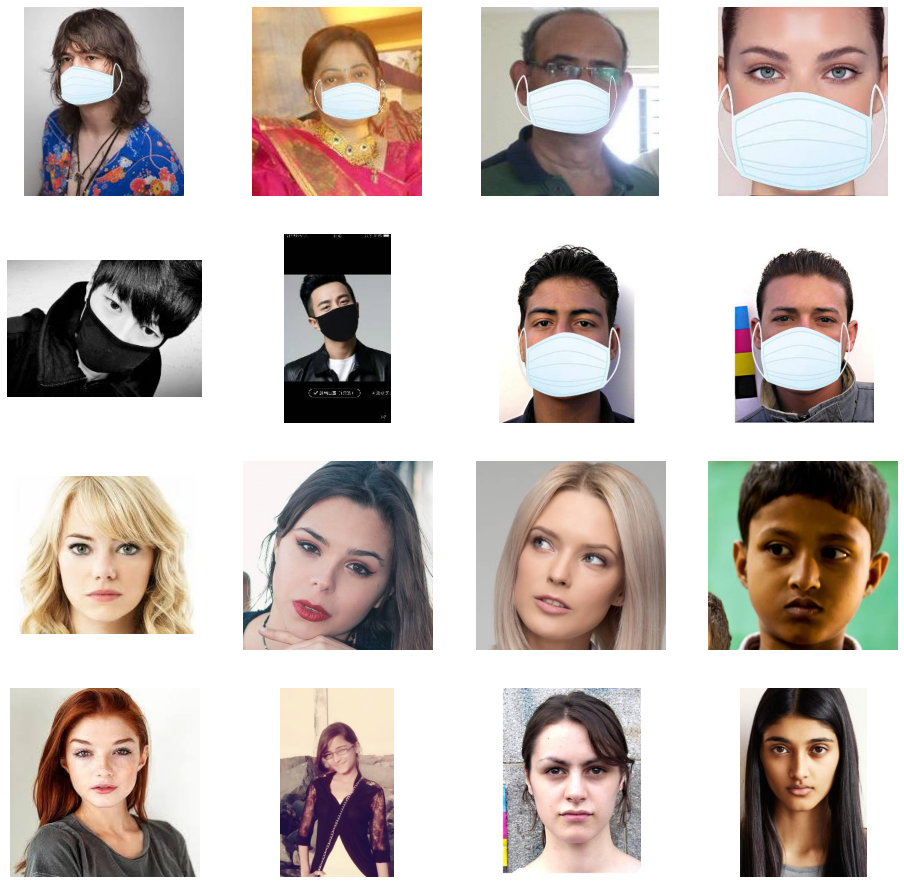

In [ ]:
# Configure matplotlib fig y ajústelo a fotos de 4x4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_with_mask_pix = [os.path.join(with_mask_dir, fname) 
                for fname in with_mask_fnames[ pic_index-8:pic_index] 
               ]

next_without_mask_pix = [os.path.join(without_mask_dir, fname) 
                for fname in without_mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_with_mask_pix+next_without_mask_pix):
  # Configurar subtrama; los índices de la subparcela comienzan en 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # No mostrar ejes (o líneas de cuadrícula)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# **Modelo propuesto**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


## Modelo con el optimizador que implementa el algoritmo RMSprop

Se formula la secuencia del modelo

In [ ]:
model1 = tf.keras.models.Sequential([
    # Tenga en cuenta que la forma de entrada es el tamaño deseado de la imagen 150x150 con 3 bytes de color
    # Primeria convolución
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolución
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cuarta convolución
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Quinta convolución
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Aplanar los resultados para incorporarlos a un DNN
    tf.keras.layers.Flatten(),
    # 512 capa oculta de neuronas
    tf.keras.layers.Dense(512, activation='relu'),
    # Solo 1 neurona de salida. Contendrá un valor de 0-1 donde 0 para 1 clase ('Tiene mascarilla') y 1 para la otra ('No tiene mascarilla)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Sumario del modelo

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

Se establece el optimizador y función de perdida

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model1.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Preprocesamiento de imagen para el conjunto de datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes serán reescaladas por 1./255.

datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

# --------------------
# Imágenes de entrenamiento de flujo en lotes de 20 usando el generador train_datagen
# --------------------
train_generator = datagen.flow_from_directory(data_dir,
                                              batch_size=20,
                                              class_mode='binary',
                                              target_size=(150, 150),
                                              subset='training')     
# --------------------
# Imágenes de validación de flujo en lotes de 20 usando el generador train_datagen
# --------------------
validation_generator =  datagen.flow_from_directory(data_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='validation')

Found 2082 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


Defina una Callback class que detiene el entrenamiento una vez que la precisión alcanza el 99%

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.98 and logs.get('accuracy') >= 0.999):
      print("\n¡Alcanzó el 99.9% de precisión, cancelando el entrenamiento!")
      self.model.stop_training = True

Entrenamiento del modelo

In [ ]:
callbacks = myCallback()
history = model1.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // 20,
                    epochs=50,
                    validation_steps=validation_generator.samples // 20,
                    callbacks=[callbacks])

Epoch 1/50
117/117 [==============================] - 24s 203ms/step - loss: 0.0794 - accuracy: 0.9944 - val_loss: 1.6449 - val_accuracy: 0.9750
Epoch 2/50
117/117 [==============================] - 24s 202ms/step - loss: 0.0445 - accuracy: 0.9944 - val_loss: 1.4770 - val_accuracy: 0.9750
Epoch 3/50
117/117 [==============================] - 24s 203ms/step - loss: 0.0364 - accuracy: 0.9970 - val_loss: 0.8218 - val_accuracy: 0.9708
Epoch 4/50
117/117 [==============================] - 24s 201ms/step - loss: 0.0451 - accuracy: 0.9966 - val_loss: 1.1086 - val_accuracy: 0.9708
Epoch 5/50
117/117 [==============================] - 24s 201ms/step - loss: 0.0500 - accuracy: 0.9961 - val_loss: 1.0188 - val_accuracy: 0.9708
Epoch 6/50
117/117 [==============================] - 24s 201ms/step - loss: 0.0170 - accuracy: 0.9957 - val_loss: 0.1397 - val_accuracy: 0.9875
Epoch 7/50
117/117 [==============================] - 24s 202ms/step - loss: 0.0249 - accuracy: 0.9974 - val_loss: 0.3932 - val_ac

Rendimiento del modelo

Text(0.5, 1.0, 'Pérdida de entrenamiento y validación')

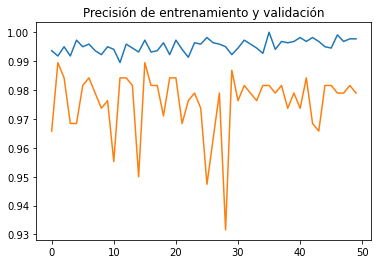

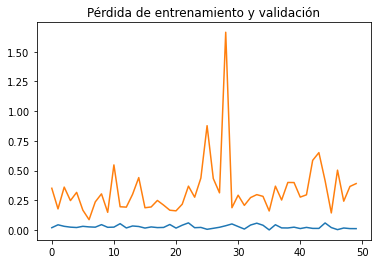

In [ ]:
#-----------------------------------------------------------
# Recupere una lista de resultados de la lista de conjuntos de datos de 
# entrenamiento y prueba para cada época de entrenamiento
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Obtener número de épocas

#------------------------------------------------
# Trazar la precisión del entrenamiento y la validación por época
#------------------------------------------------
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Precisión de entrenamiento y validación')
plt.figure()

#------------------------------------------------
# Trazar pérdida de validación y entrenamiento por época
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Pérdida de entrenamiento y validación')

Prueba con imagenes fuera del conjunto de datos

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model2.predict(images, batch_size=20)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " No tiene mascarilla")   
  else:
    print(fn + " Tiene mascarilla")

## Modelo con el optimizador Adam

Se formula la secuencia del modelo

In [ ]:
model2 = tf.keras.models.Sequential([
    # Tenga en cuenta que la forma de entrada es el tamaño deseado de la imagen 150x150 con 3 bytes de color
    # Primeria convolución
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolución
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cuarta convolución
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Quinta convolución
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Aplanar los resultados para incorporarlos a un DNN
    tf.keras.layers.Flatten(),
    # 512 capa oculta de neuronas
    tf.keras.layers.Dense(512, activation='relu'),
    # Solo 1 neurona de salida. Contendrá un valor de 0-1 donde 0 para 1 clase ('Tiene mascarilla') y 1 para la otra ('No tiene mascarilla)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Sumario del modelo

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

Se establece el optimizador y función de perdida

In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Preprocesamiento de imagen para el conjunto de datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes serán reescaladas por 1./255.

datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

# --------------------
# Imágenes de entrenamiento de flujo en lotes de 20 usando el generador train_datagen
# --------------------
train_generator = datagen.flow_from_directory(data_dir,
                                              batch_size=20,
                                              class_mode='binary',
                                              target_size=(150, 150),
                                              subset='training')     
# --------------------
# Imágenes de validación de flujo en lotes de 20 usando el generador train_datagen
# --------------------
validation_generator =  datagen.flow_from_directory(data_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='validation')

Found 2213 images belonging to 2 classes.
Found 389 images belonging to 2 classes.


Defina una Callback class que detiene el entrenamiento una vez que la precisión alcanza el 98.5%

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.99 and logs.get('accuracy') >= 0.99):
      print("\n¡Alcanzó el 98.5% de precisión, cancelando el entrenamiento!")
      self.model.stop_training = True

Entrenamiento del modelo

In [ ]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // 20,
                    epochs=50,
                    validation_steps=validation_generator.samples // 20,
                    callbacks=[callbacks])

Epoch 1/30
110/110 [==============================] - 25s 223ms/step - loss: 0.4630 - accuracy: 0.7649 - val_loss: 0.1279 - val_accuracy: 0.9658
Epoch 2/30
110/110 [==============================] - 24s 223ms/step - loss: 0.2110 - accuracy: 0.9161 - val_loss: 0.0969 - val_accuracy: 0.9737
Epoch 3/30
110/110 [==============================] - 24s 222ms/step - loss: 0.1857 - accuracy: 0.9372 - val_loss: 0.0655 - val_accuracy: 0.9763
Epoch 4/30
110/110 [==============================] - 24s 220ms/step - loss: 0.1875 - accuracy: 0.9405 - val_loss: 0.0580 - val_accuracy: 0.9816
Epoch 5/30
110/110 [==============================] - 24s 221ms/step - loss: 0.1619 - accuracy: 0.9361 - val_loss: 0.0645 - val_accuracy: 0.9684
Epoch 6/30
110/110 [==============================] - 24s 222ms/step - loss: 0.1470 - accuracy: 0.9397 - val_loss: 0.0563 - val_accuracy: 0.9763
Epoch 7/30
110/110 [==============================] - 24s 222ms/step - loss: 0.1290 - accuracy: 0.9531 - val_loss: 0.0874 - val_ac

Rendimiento del modelo

Text(0.5, 1.0, 'Pérdida de entrenamiento y validación')

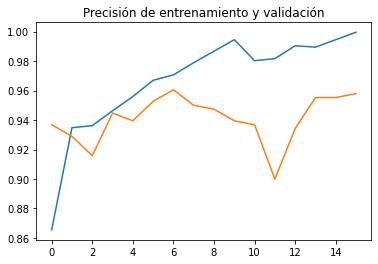

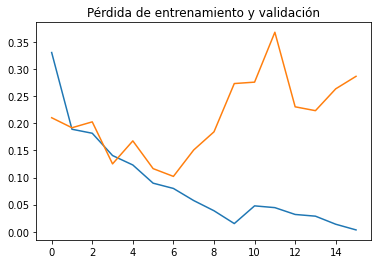

In [ ]:
#-----------------------------------------------------------
# Recupere una lista de resultados de la lista de conjuntos de datos de 
# entrenamiento y prueba para cada época de entrenamiento
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Obtener número de épocas

#------------------------------------------------
# Trazar la precisión del entrenamiento y la validación por época
#------------------------------------------------
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Precisión de entrenamiento y validación')
plt.figure()

#------------------------------------------------
# Trazar pérdida de validación y entrenamiento por época
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Pérdida de entrenamiento y validación')

Prueba con imagenes fuera del conjunto de datos

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model2.predict(images, batch_size=20)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " No tiene mascarilla")   
  else:
    print(fn + " Tiene mascarilla")

# Convertir el modelo a TFLite

In [ ]:
converter_1 = tf.lite.TFLiteConverter.from_keras_model(model1)
converter_2 = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model_1 = converter_1.convert()
tflite_model_2 = converter_2.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7x1qh39c/assets


INFO:tensorflow:Assets written to: /tmp/tmp7x1qh39c/assets


INFO:tensorflow:Assets written to: /tmp/tmpvn0ve3wt/assets


INFO:tensorflow:Assets written to: /tmp/tmpvn0ve3wt/assets


In [ ]:
open("model_1.tflite","wb").write(tflite_model_1)


37981968

In [ ]:
open("model_2.tflite","wb").write(tflite_model_2)

37982072